In [1]:
import os
from openai import OpenAI
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pprint import pprint
import time
import requests
import os

In [2]:
possible_links = ["https://portal.nccs.nasa.gov/datashare/giss_cmip6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f2/Amon/hus/gn/v20190903/",
                  "https://portal.nccs.nasa.gov/datashare/giss_cmip6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f2/Amon/pr/gn/v20190903/",
                  "https://portal.nccs.nasa.gov/datashare/giss_cmip6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f2/Amon/tas/gn/v20190903/",
                  "https://portal.nccs.nasa.gov/datashare/giss_cmip6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f2/CFday/cct/gn/v20190903/"
                  ]

In [3]:
if not os.environ.get("OPENAI_API_KEY"):
    import key
    key.init()
    assert os.environ.get('OPENAI_API_KEY')
    
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [4]:
def create_file(path="pr_Amon_GISS-E2-1-G_ssp245_r10i1p1f2_gn_201501-205012.nc"):
    file = client.files.create(
        file=open(path, "rb"),
        purpose='assistants'
    )
    return file


def create_assistant(file):
    assistant = client.beta.assistants.create(
        name="Climate PAL Assistant",
        instructions="You are a climate scientist that is an expert in analyzing and plotting data. When asked a climate science question, write and run code to answer the question. Use the xarray library to read .nc files. Download and use the cftime library to decode time variables",
        tools=[{"type": "code_interpreter"}],
        model="gpt-4o",
        # I need to figure out what this does
        tool_resources={
        "code_interpreter": {
        "file_ids": [file.id]
        }
        }
    )
    return assistant
  
def create_thread(text_body=''):
  thread = client.beta.threads.create()
  message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content = text_body
  )
  print("Here is the message we just created: ", message)
  return thread
  
def create_message(thread, text_body=''):
  message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content = text_body
  )
  print("Here is the message we just created: ", message)
  return message



def download_file(url):
    # Send a HTTP request to the URL
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Extract the filename from the URL
        local_filename = os.path.basename(url)
        
        # Open a local file with write-binary mode
        with open("data/"+local_filename, "wb") as file:
            # Write the contents of the response to the file
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Download completed successfully. File saved as {local_filename}")
    else:
        print("Failed to download the file. Status code:", response.status_code)
        
    return local_filename    

In [5]:
file = create_file()
assistant = create_assistant(file)
thread = create_thread("Create a plot of total rainfall")
create_message(thread, "ignore this sentence, I just want to see how the history works")



Here is the message we just created:  Message(id='msg_danPFh85R9nVjYXmmI7HotsG', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='Create a plot of total rainfall'), type='text')], created_at=1721297693, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_wQLrwFp7deX7aVmVjqmetlTJ')
Here is the message we just created:  Message(id='msg_8pGJqPKVwKgttYAhh9Uqno0y', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='ignore this sentence, I just want to see how the history works'), type='text')], created_at=1721297693, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_wQLrwFp7deX7aVmVjqmetlTJ')


Message(id='msg_8pGJqPKVwKgttYAhh9Uqno0y', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='ignore this sentence, I just want to see how the history works'), type='text')], created_at=1721297693, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_wQLrwFp7deX7aVmVjqmetlTJ')

In [6]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
)

In [7]:
run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
print(run.status)


queued


In [8]:
while run.status not in ["completed", "failed"]:
  run = client.beta.threads.runs.retrieve(
    thread_id = thread.id,
    run_id = run.id
  )

  print(run.status)
  time.sleep(5)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed


In [9]:
messages = client.beta.threads.messages.list(thread_id=thread.id)
print(messages)

SyncCursorPage[Message](data=[Message(id='msg_FE7GIoCRjdIwph6iNlv5yXdM', assistant_id='asst_WMtCqvsSAdRXoymTW8ODhk2g', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-SdueXF0G4tINSLhcJWIyc5ot', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here is the plot showing the total rainfall over the provided time period. The values are summed over the given time dimensions to produce the spatial distribution of total rainfall.\n\nIf you need any further analysis or another specific visualization, please let me know!'), type='text')], created_at=1721297798, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_CGFbHqHs9nYps6XtMy8yflyE', status=None, thread_id='thread_wQLrwFp7deX7aVmVjqmetlTJ'), Message(id='msg_JqEObtdUlMzGsyTMJBnMYqOh', assistant_id='asst_WMtCqvsSAdRXoymTW8ODhk2g', attachments=[], completed_at=None, content=[TextContentBlock(text=

In [10]:
pprint(messages)

SyncCursorPage[Message](data=[Message(id='msg_FE7GIoCRjdIwph6iNlv5yXdM', assistant_id='asst_WMtCqvsSAdRXoymTW8ODhk2g', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-SdueXF0G4tINSLhcJWIyc5ot', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='Here is the plot showing the total rainfall over the provided time period. The values are summed over the given time dimensions to produce the spatial distribution of total rainfall.\n\nIf you need any further analysis or another specific visualization, please let me know!'), type='text')], created_at=1721297798, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_CGFbHqHs9nYps6XtMy8yflyE', status=None, thread_id='thread_wQLrwFp7deX7aVmVjqmetlTJ'), Message(id='msg_JqEObtdUlMzGsyTMJBnMYqOh', assistant_id='asst_WMtCqvsSAdRXoymTW8ODhk2g', attachments=[], completed_at=None, content=[TextContentBlock(text=

user: Create a plot of total rainfall
user: ignore this sentence, I just want to see how the history works
assistant: Great, let's start by examining the uploaded file. We'll check its contents, read any relevant data, and then proceed to create a plot of total rainfall.

First, let's load the file and inspect its contents.
assistant: It seems the file uses a non-standard calendar format (365_day) which is not directly supported by pandas. We need to use the `cftime` library to handle this calendar format. Let's decode the time variables using cftime and then proceed to analyze the data.
assistant: It appears the `cftime` library is not installed in the current environment. Let's install `cftime` and then proceed with decoding the time variable.
assistant: It looks like there is no internet access to install the `cftime` package directly. We need to open the dataset without decoding the time variable, and then we can manually handle the time decoding.

Let's proceed by opening the data

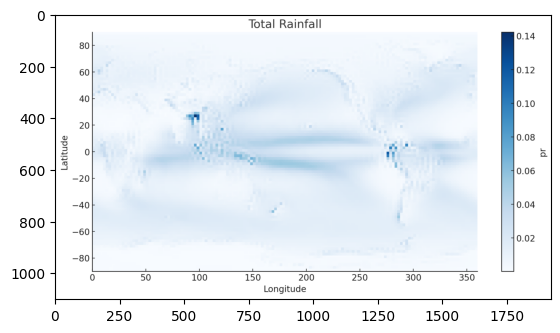

In [11]:
for message in reversed(messages.data):
    content_block = message.content[0]
    
    if hasattr(content_block, 'text'):
        print(message.role + ": " + content_block.text.value)
        
    elif hasattr(content_block, 'image_file'):
        # print(content_block.image_file)
        print(message.role + ": [Non-text content]")
        # print(content_block)
        # print(content_block.image_file.file_id)
        
        api_response = client.files.with_raw_response.retrieve_content(content_block.image_file.file_id)

        content = api_response.content
        with open(f"assistant_images/{content_block.image_file.file_id}.png", 'wb') as f:
            f.write(content)
        
        image_path = f"assistant_images/{content_block.image_file.file_id}.png"

        img = mpimg.imread(image_path)
        plt.imshow(img)
        print('File downloaded successfully.')



In [12]:
response = client.beta.assistants.delete(assistant.id)
print(response)

response = client.files.delete(file)
print(response)

AssistantDeleted(id='asst_WMtCqvsSAdRXoymTW8ODhk2g', deleted=True, object='assistant.deleted')


NotFoundError: Error code: 404 - {'error': {'message': "No such File object: FileObject(id='file-HRuRVNU56PuXGRztQDVw0i5m', bytes=22424788, created_at=1721297692, filename='pr_Amon_GISS-E2-1-G_ssp245_r10i1p1f2_gn_201501-205012.nc', object='file', purpose='assistants', status='processed', status_details=None)", 'type': 'invalid_request_error', 'param': 'id', 'code': None}}